# Train a model

__Before starting with "Train a model":__ you should read the notebook Create_train_dataset.ipynb and create a dataset

- 1- Create a data generator
- 2- Create a model/architecture
- 3- Train the model

## 1- Create a data generator

- __Create a data augmentation generator__ using Augmentor (module from pip) and Augmentor_add_on (Thibault addon in /unet_4_user/Augmentor_add_on.py)


- __Import the data.__ Data should be patches of size 256x256 or 512x512 in pair (image, mask)
    - Data are contained 2 sets: Data_train and Data_validation
    - Follow the guide from the notebook Create_training_dataset.ipynb to create a dataset with the appropriate structure. Example on dataset (and its structure for references) is located in /DataSet_demo/Patch_for_Training


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import json
from keras.models import model_from_json
import datetime

import Augmentor

from tkinter import filedialog
from tkinter import Tk

Using TensorFlow backend.


In [2]:
from utility.Utility import Import_image
from utility.Utility_Dataset import get_data
from utility.Apply_model import Import_model, Unet_by_patches
import utility.Augmentor_add_on as aug_addon
from utility.Training_tools import train_UnAxSeg

### 1.1 Create generator function

This function is used to generate a data augmentation generator.
it is not necessary to change the parameters of the different transformation as they correspond to range of value randomly picked during the data augmentation generation.
The parameter probability define the probability that the transformation takes place.

Recommended range for :
        - rotate : max 15, min 0
        - distortion : ???
        - shear : 15
        


In [3]:
# Create a generator
def Generator_Augmented_Data(Data_train, batch_size=10):
    
    p = Augmentor.DataPipeline(Data_train)
    
    p.rotate(probability=0.9, max_left_rotation=15, max_right_rotation=15)
    p.rotate90(probability=0.8)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.random_distortion(probability=1,grid_width=1, grid_height=1, magnitude=8)
    p.shear(0.9,max_shear_left=10, max_shear_right=10)
    
    mask_3ch = aug_addon.Mask_3ch() # convert the masks in 3 channels with 0 or 1 value (hotshot)
    p.add_operation(mask_3ch)
    
    g =   p.keras_generator_with_mask(batch_size=batch_size)
    return g

### 1.2 Create generator for training data

- 1- Select the path where the training set image/mask are located
- 2- Create the iterator (generator) using the training set
- 3- Sanity check (size, shape and plot)
- 4- Repeat 1 and 2 for validation set

In [4]:
# option 1 Choose the location of the dataset manually
train_path = 'Data/dataset_demo/Patch_for_Training/train'

In [4]:
# option 2 Choose the location of the dataset using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
train_path =  filedialog.askdirectory(initialdir = './',\
                            title = 'choose directory /train containing "image*.png, mask*.png"')
print('train_path :{}'.format(train_path))

train_path :/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Dataset_demo/Patch_for_Training/train


In [5]:
# import the dataset as a list of tuple (np.array(image),np.array(mask) )
Data_train = get_data(train_path)

# Sanity check
print('list: {}'.format(type(Data_train)))
print('tuple: {}'.format(type(Data_train[0])))
print('image_shape: {0}, mask_shape: {1} '.format(Data_train[0][0].shape,Data_train[0][1].shape))

list: <class 'list'>
tuple: <class 'tuple'>
image_shape: (256, 256), mask_shape: (256, 256) 


In [7]:
# Create a data augmentation generator for training
# Choose : you can change batch_size

g_train = Generator_Augmented_Data(Data_train, batch_size=20)

there are 20 batches


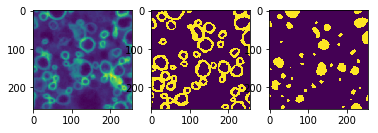

In [8]:
# Optional: Sanity check
a = next(g_train)
imgs = a[0]
masks = a[1]
print ('there are {} batches'.format(masks.shape[0]))
i=0 # choose a random value between [0-(batch_size-1)] (number of image/mask per batch)
fig, ax =plt.subplots(nrows=1,ncols=3)
ax[0].imshow(imgs[i,:,:,0])
ax[1].imshow(masks[i,:,:,1])
ax[2].imshow(masks[i,:,:,2])

### 1.3 Create generator for validation data

In [9]:
# option 1 Choose the location of the dataset manually
validation_path = 'Data/dataset_demo/Patch_for_Training/validation'

In [10]:
# option 2 Choose the location of the dataset using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
validation_path =  filedialog.askdirectory(initialdir = './',\
                            title = 'choose directory /validation containing "image*.png, mask*.png"') 

In [10]:
# import the dataset as a list of tuple (np.array(image),np.array(mask) )
Data_validation = get_data(validation_path)

# Sanity check
print('list: {}'.format(type(Data_train)))
print('tuple: {}'.format(type(Data_train[0])))
print('image: {0}, Smask: {1} '.format(Data_train[0][0].shape,Data_train[0][1].shape))

list: <class 'list'>
tuple: <class 'tuple'>
image: (256, 256), Smask: (256, 256) 


In [11]:
# Create a data augmentation generator for training
g_validation = Generator_Augmented_Data(Data_validation, batch_size=10)

10 batches


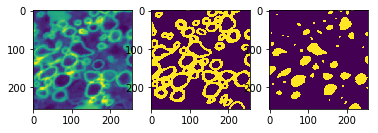

In [12]:
# Optional: Sanity check
a = next(g_validation)
imgs = a[0]
masks = a[1]
print ('{} batches'.format(masks.shape[0]))
i=0 # choose a random 0-(batch_size-1) (number of image/mask per batch)
fig, ax =plt.subplots(nrows=1,ncols=3)
ax[0].imshow(imgs[i,:,:,0])
ax[1].imshow(masks[i,:,:,1])
ax[2].imshow(masks[i,:,:,2])

## 2- Create a model architecture and train

In [13]:
# Create a name for the model witht the date and time of the training
currentDT = datetime.datetime.now()
date_time = currentDT.strftime("%Y-%m-%d_%H%M")
model_path = 'Models/'+ date_time +'.h5'
print ("your model will be save at : {}".format(model_path))

your model will be save at : Models/2019-06-06_1840.h5


In [14]:
from time import time
import os
from keras.callbacks import TensorBoard
log_path = "logs/{}".format(time())
tensorboard = TensorBoard(log_dir=log_path)

log_path = os.path.join(os.getcwd(),log_path)
print ("log_path : \n", log_path)

log_path = os.path.join(os.getcwd(),'logs')
tb_com_line =  'tensorboard --logdir={} &'.format(log_path)
print("To run in terminal:\n {}".format( tb_com_line))

log_path : 
 /home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/logs/1559839254.7710855
To run in terminal:
 tensorboard --logdir=/home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/logs &


## Open Tensorboard : to monitor progress
###  __In terminal command__ : Copy and execute the following

To kill the process linked to the port 6006 used by tensorflow
 - lsof -i -P -n | grep 6006
 - kill -9 $(lsof -t -i :6006 -s TCP:LISTEN)
 - tensorboard --logdir=<~/user/../logs (use the output from next cell
 - firefox http://localhost:6006 (if tensorboard is running just click on the link)
 
Alternatively run the cell "Start automatical tensorboard

In [21]:
# Start automatical tensorboard
# Run this command to open the port for tensorboard
# if the /logs folder is empty (first time you are using it or folder has been clean, run those commands
# separately in a terminal after starting the train)
with open ('run.sh', 'w') as rsh:
    rsh.write('''#! /bin/bash
    kill -9 $(lsof -t -i :6006 -s TCP:LISTEN)
    tensorboard --logdir={0} &
    '''.format(os.path.join(os.getcwd(),'logs')))
os.chmod('run.sh', 0o755)

from subprocess import call
rc = call("./run.sh")

os.remove('run.sh')

In [15]:
# Run the training
# Choose 
epochs = 600
steps_per_epoch = 10

train_UnAxSeg (img_size= 256, train_generator=g_train, val_generator=g_validation,
                   steps_per_epoch= steps_per_epoch, epochs= epochs,
                   model_path=model_path, tensorboard = tensorboard)

Epoch 1/600
10/10 [==============================] - 5s 547ms/step - loss: 0.7034 - acc: 0.4356 - dice_coef_ch1: 0.5269 - dice_coef_ch2: 0.2644 - val_loss: 0.6137 - val_acc: 0.4772 - val_dice_coef_ch1: 0.6621 - val_dice_coef_ch2: 0.3145
Epoch 2/600
10/10 [==============================] - 2s 171ms/step - loss: 0.6074 - acc: 0.4936 - dice_coef_ch1: 0.6510 - dice_coef_ch2: 0.3053 - val_loss: 0.8257 - val_acc: 0.4506 - val_dice_coef_ch1: 0.5914 - val_dice_coef_ch2: 0.3390
Epoch 3/600
10/10 [==============================] - 2s 171ms/step - loss: 0.5627 - acc: 0.5273 - dice_coef_ch1: 0.6935 - dice_coef_ch2: 0.3341 - val_loss: 0.6922 - val_acc: 0.4126 - val_dice_coef_ch1: 0.6098 - val_dice_coef_ch2: 0.3816
Epoch 4/600
10/10 [==============================] - 2s 183ms/step - loss: 0.5404 - acc: 0.5927 - dice_coef_ch1: 0.7103 - dice_coef_ch2: 0.3517 - val_loss: 0.6253 - val_acc: 0.4378 - val_dice_coef_ch1: 0.7005 - val_dice_coef_ch2: 0.4135
Epoch 5/600
10/10 [==============================] -

KeyboardInterrupt: 

## 3-  Test


In [5]:
# option 1 Choose the test image of the dataset manually
test_path = 'Data/dataset_demo/test/sample5/image.png'

In [20]:
# option 2 Choose the image to test using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
test_path =  filedialog.askopenfilename(initialdir = './',\
                            title = 'choose the image to test "image.png') 

In [6]:
img_test, _ = Import_image(filename = test_path)

In [9]:
# If you want to test an other model that the one you just trained
# change it here
# option 2 Choose the location of the dataset using a dialog box
root = Tk()
root.withdraw()# we don't want a full GUI, so keep the root window from appearing
model_path =  filedialog.askopenfilename(initialdir = './Models',\
                            title = 'Choose the model to test "*.h5"') 

In [10]:
# import the model
model_to_test=Import_model(model_path = model_path)
print('we are using the model: {}'.format(model_path))

we are using the model: /home/thibault/Documents/Thibault_Python_dev/UnAxSeg/unet_4_user/Models/model_in_use.h5


In [11]:
prediction = Unet_by_patches(img_test, model_to_test, patch_size=256, overlap=64, RGB = True)

100%|██████████| 25/25 [00:01<00:00,  6.49it/s]


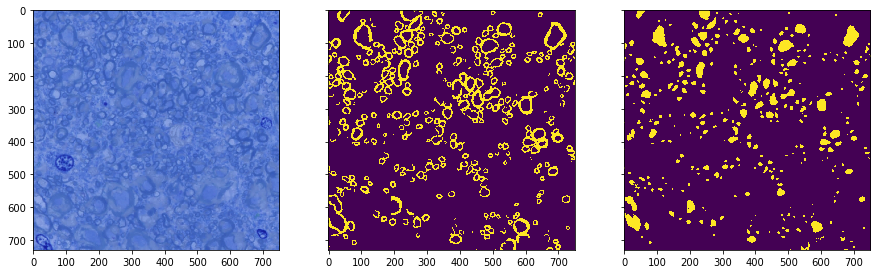

In [12]:
# Create the mask using argmax apply in 3th dimension
mask = np.argmax(prediction, axis=-1)

pred_axon = mask== 2
pred_myelin = mask == 1

# Plot image and mask
myelin_mask = np.array(mask==1, dtype= np.uint8)
axon_mask = np.array(mask==2, dtype= np.uint8)

fig, ax = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=True, figsize=(15,10))
ax[0].imshow(np.array(img_test))
ax[1].imshow(myelin_mask)
ax[2].imshow(axon_mask)

## 4- Performance check

__Todo__